In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import gc
import time
import torchvision
import random
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Data orgenizing for dataloaders
class ImageDataset(Dataset):
    def __init__(self, dataset_type):
        self.paths_labels = []
        prefix = "archive\\chest_xray\\chest_xray\\" + dataset_type + "\\"
        for item in os.listdir(prefix):
            for img_path in os.listdir(prefix + item):
                if 'bacteria' in img_path:
                    label = 1
                elif 'virus' in img_path:
                    label = 1
                else: 
                    label = 0
                self.paths_labels.append((prefix + item + "\\" + img_path, label))
        self.size = len(self.paths_labels)
        self.train = False

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        img_path, label = self.paths_labels[idx]
        feature = Image.open(img_path).convert('RGB')  # Ensure RGB format for color augmentations
        label = torch.tensor(label, dtype=torch.long)

        # Define data augmentation transformations
        data_augmentation = transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
        ])

        # Apply data augmentation
        feature = data_augmentation(feature)

        return feature, label
    
g = torch.Generator()
g.manual_seed(0)

train_dataset = ImageDataset('train')
val_dataset = ImageDataset('val')
test_dataset = ImageDataset('test')

# Increase the validation datset, taking 400 samples from the train dataset
selected_elements = random.sample(train_dataset.paths_labels, 400)
train_dataset.paths_labels = [elem for elem in train_dataset.paths_labels if elem not in selected_elements]
val_dataset.paths_labels.extend(selected_elements)
train_dataset.size = len(train_dataset.paths_labels)
val_dataset.size = len(val_dataset.paths_labels)

# defining dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True,
                              generator=g)
val_dataloader = DataLoader(val_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              pin_memory=True,
                              generator=g)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True,
                             generator=g)

In [5]:
# Transfer learning model from resnet 101
resnet = torchvision.models.resnet101(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 1000)
for param in resnet.fc.parameters():
    param.requires_grad = True

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = resnet
        self.dense = nn.Linear(1000, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.backbone(x)
        self.embedding = x.detach()  # for saving the activations at the end
        x = self.relu(x)
        x = self.dense(x)
        return x

In [6]:
# Fancy graphics while training
def show_progress(epoch, step, total_steps, loss, added_text='', width=30, bar_char='█', empty_char='░'):
    print('\r', end='')
    progress = ""
    for i in range(width):
        progress += bar_char if i < int(step / total_steps * width) else empty_char
    print(f"epoch:{epoch + 1} [{progress}] {step}/{total_steps} loss: {loss:.4f}" + added_text, end='')

In [7]:
# Scheduler for AdamW
class WarmupCosineSchedule(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, t_total):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        super(WarmupCosineSchedule, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [self.last_epoch / max(1, self.warmup_steps) * base_lr for base_lr in self.base_lrs]
        return [0.5 * (1.0 + np.cos(np.pi * (self.last_epoch - self.warmup_steps) / (self.t_total - self.warmup_steps))) *
                base_lr for base_lr in self.base_lrs]

In [8]:
# Acc calculation
def estimate_acc(predicted, true):
    return (torch.argmax(predicted, dim=-1) == true).sum() / true.shape[0]

In [9]:
epochs = 10
gc.collect()
torch.cuda.empty_cache()
model = Model()
model.to(device)
loss = nn.CrossEntropyLoss()

# A more stable version of Adam, works well with a scedualer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.005)
scheduler = WarmupCosineSchedule(optimizer, warmup_steps=5, t_total=epochs*len(train_dataloader))

model.train()
losses_train = []
accs_train = []
losses_val = []
accs_val = []
taken = 0
best_val_acc = 0

In [10]:
# Estimates performance of the model on a loader
@torch.no_grad()
def estimate_performance(loader):
    model.eval()
    running_loss = 0.0
    iters = 0
    acc = 0
    for x, y in loader:
        iters += 1
        x = x.to(device)
        y = y.to(device)
        with torch.autocast(device.type):
            output = model.forward(x)
            loss_val = loss(output, y)
        x.detach()
        output.detach()
        y.detach()
        running_loss += loss_val.item()
        acc += estimate_acc(output, y).item()
    val_loss = running_loss / iters
    acc /= iters
    model.train()
    return val_loss, acc

In [11]:
# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    acc = 0.0
    start = time.time()
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device.type):
            output = model.forward(x)
            loss_val = loss(output, y)
        loss_val.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        x.detach()
        y.detach()
        output.detach()
        scheduler.step()
        with torch.no_grad():
            running_loss += loss_val.item()
            acc += estimate_acc(output.contiguous(), y.contiguous()).item()
            if i % 10 == 0:
                show_progress(
                    epoch,
                    i,
                    len(train_dataloader),
                    running_loss / (i + 1),
                    f" train acc: {acc/(i + 1):.4f}",
                )
    with torch.no_grad():
        acc /= len(train_dataloader)
        running_loss /= len(train_dataloader)
        losses_train.append(running_loss)
        accs_train.append(acc)
        val_loss, val_acc = estimate_performance(val_dataloader)
        losses_val.append(val_loss)
        accs_val.append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "saved_model.pt")  # save model weights
            taken = epoch + 1
        show_progress(
            epoch,
            i,
            len(train_dataloader),
            running_loss,
            f" train acc: {acc:.4f}"
            + f" val loss: {val_loss:.4f} acc: {val_acc:.4f}"
            + f" time: {time.time() - start:.4f}",
        )
        print()
print(f"taken = {taken} {best_val_acc}")

epoch:1 [█████████████████████████████░] 150/151 loss: 0.3702 train acc: 0.8313 val loss: 0.3458 acc: 0.8438 time: 99.0440
epoch:2 [█████████████████████████████░] 150/151 loss: 0.2609 train acc: 0.8911 val loss: 0.3824 acc: 0.8438 time: 95.7054
epoch:3 [█████████████████████████████░] 150/151 loss: 0.2842 train acc: 0.8796 val loss: 0.2312 acc: 0.9087 time: 97.1053
epoch:4 [█████████████████████████████░] 150/151 loss: 0.2339 train acc: 0.9011 val loss: 0.3142 acc: 0.8750 time: 111.0442
epoch:5 [█████████████████████████████░] 150/151 loss: 0.2517 train acc: 0.8945 val loss: 0.2408 acc: 0.9062 time: 107.2661
epoch:6 [█████████████████████████████░] 150/151 loss: 0.2198 train acc: 0.9067 val loss: 0.2064 acc: 0.9231 time: 142.9188
epoch:7 [█████████████████████████████░] 150/151 loss: 0.2161 train acc: 0.9123 val loss: 0.2081 acc: 0.9135 time: 145.7102
epoch:8 [█████████████████████████████░] 150/151 loss: 0.2020 train acc: 0.9170 val loss: 0.2046 acc: 0.8990 time: 145.7030
epoch:9 [██

In [12]:
# clear cuda memory
del x
del y
del output

In [13]:
# Data testing
checkpoint = torch.load('saved_model1.1b.pt')
model.load_state_dict(checkpoint)

test_loss, test_acc = estimate_performance(test_dataloader)

print(f'test loss: {test_loss:.4f} test acc: {test_acc:.4f}')

test loss: 0.3697 test acc: 0.8734


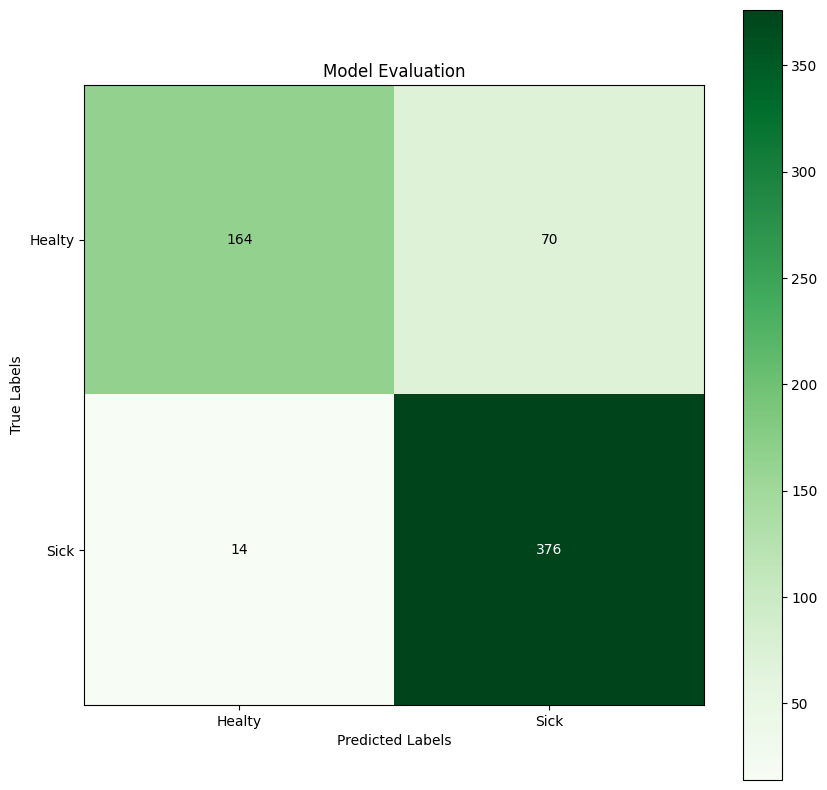

In [14]:
# Confusion matrix for evaluation
label_mapping = {0: 'Healty', 1: 'Sick'}

all_preds = []
all_targets = []
model.eval()
for i, (feature, target) in enumerate(test_dataloader):
    feature, target = feature.to(device), target.to(device)
    with torch.no_grad():
        with torch.autocast('cuda'):
            output = model.forward(feature)

        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

str_labels = [label_mapping[i] for i in range(len(label_mapping))]
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Model Evaluation')
plt.colorbar()
tick_marks = range(len(str_labels))
plt.xticks(tick_marks, str_labels)
plt.yticks(tick_marks, str_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(str_labels)):
    for j in range(len(str_labels)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [15]:
# KNN model
neigh = KNeighborsClassifier(n_neighbors=7)
X = None
Y = None

with torch.no_grad():
    for i, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            with torch.autocast('cuda'):
                output = model.forward(x)
            x.detach()
            y.detach()
            if X is None:
                X = model.embedding.cpu().numpy()
                Y = y.cpu().numpy()
            else:
                X = np.concatenate((X, model.embedding.cpu().numpy()), axis=0)
                Y = np.concatenate((Y, y.cpu().numpy()), axis=0)
            output.detach()

neigh.fit(X, Y)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 86.06%


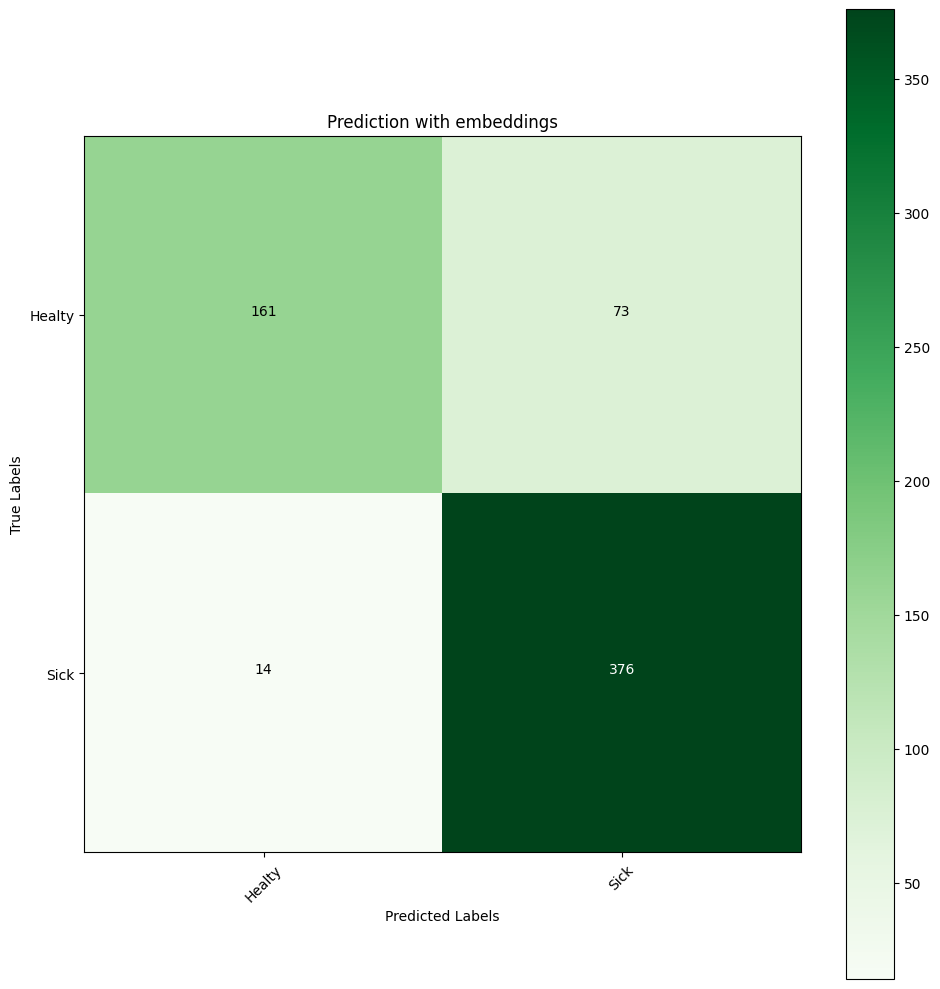

In [16]:
# Confusion matrix for evaluation
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test = None
all_preds = []
all_targets = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        with torch.autocast('cuda'):
            output = model(x)
        x.detach()

        if X_test is None:
            X_test = model.embedding.cpu().numpy()
        else:
            X_test = np.concatenate((X_test, model.embedding.cpu().numpy()), axis=0)

        all_targets.extend(y.cpu().numpy())

preds = neigh.predict(X_test)
all_preds.extend(preds)

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

str_labels = [label_mapping[i] for i in range(len(label_mapping))]
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Prediction with embeddings')
plt.colorbar()
tick_marks = np.arange(len(str_labels))
plt.xticks(tick_marks, str_labels, rotation=45)
plt.yticks(tick_marks, str_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()

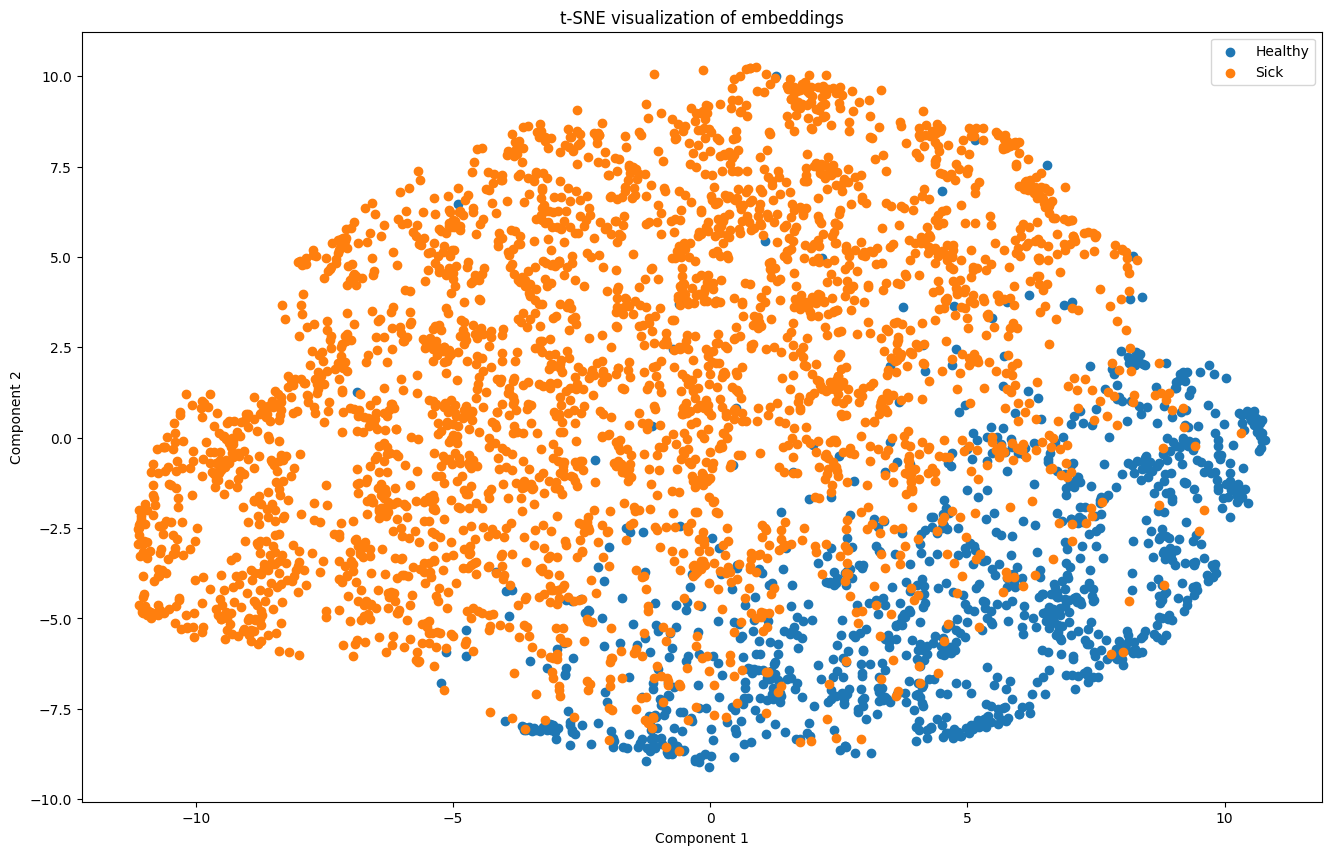

In [17]:
# t-SNE graphics
n_samples = 4000
classes = ['Healthy', 'Sick']

embeddings = X[:n_samples, ...]
labels = Y[:n_samples]

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(16,10))
for i in range(2):
    indices = labels == i
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'{classes[i]}')
plt.legend()
plt.title('t-SNE visualization of embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()